In [18]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
plt.rcParams['figure.figsize'] = (14, 10)

%reload_ext autoreload
%autoreload 2



In [7]:
import os

In [187]:
import fix

node_str = "gate diff load ref drive lpf i(vbatt) i(vload)"

ksf = fix.KicadSpiceFix('../hc.cir')

ksf.set_lines('include', [
    '.INCLUDE bc337.model',
    '.INCLUDE diodes.lib',
    '.INCLUDE LM358.101',
    '.INCLUDE tl431.lib',    
    '.INCLUDE sihf540.lib'])

##########STDERR##########

Note: No ".plot", ".print", or ".fourier" lines; no simulations run



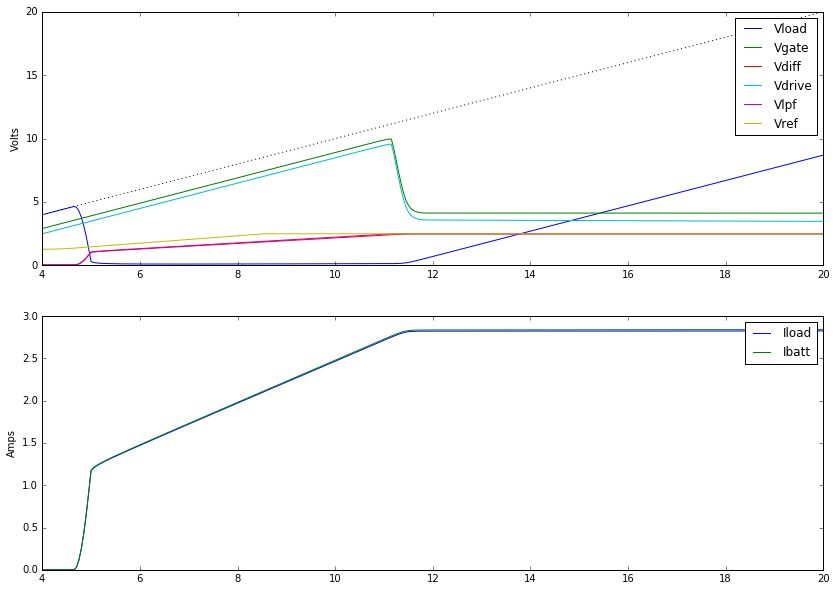

In [189]:
try:
    os.remove('out1.data')
except:
    pass

ksf.device('RV1').adjust(0.5)


ksf.set_lines('extern', [
    'Vbatt VCC GND 12V',
    'Vdis disable GND 0V',
    'Rload VCC l1 4R',
    'Vload l1 LOAD 0V'    
    ])

ksf.set_lines('control', [
    '.control',
    'dc Vbatt 4 20 0.05',
    'wrdata out1 ' + node_str,
    '.endc'])

        
ksf.write_and_run('t1.cir')


Vc, V, I = fix.read_wrdata_file('out1.data', node_str)

I['batt'] = -I["batt"]

fix.plot_all(Vc, V, I)
plt.subplot(2,1,1)
plt.plot(Vc, Vc, ':k')

##########STDERR##########

Note: No ".plot", ".print", or ".fourier" lines; no simulations run



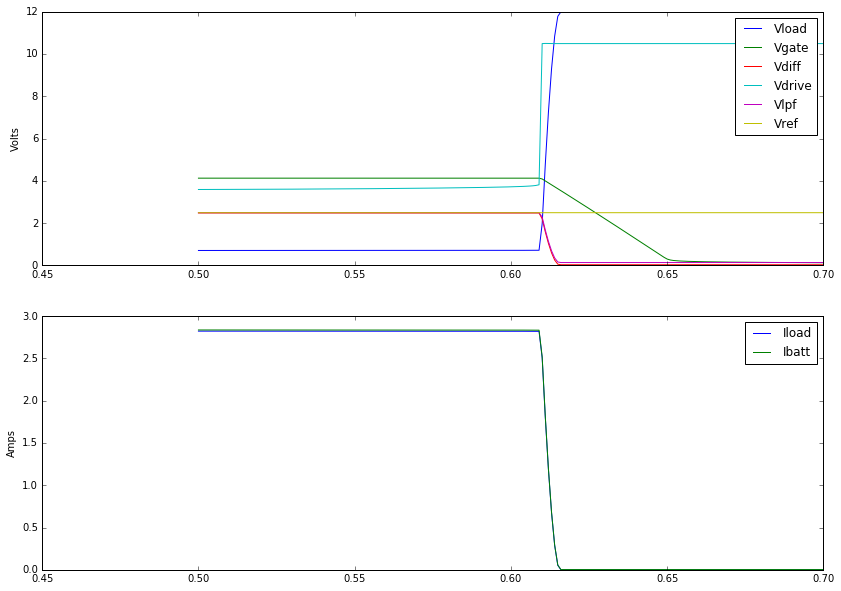

In [191]:
ksf.set_lines('control', [
    '.control',
    'dc Vdis 0.5 0.7 0.001',
    'wrdata out2 ' + node_str,
    '.endc'])

ksf.write_and_run('t2.cir')

Vc, V, I = fix.read_wrdata_file('out2.data', node_str)

I['batt'] = -I["batt"]

fix.plot_all(Vc, V, I)    

##########STDERR##########

Note: No ".plot", ".print", or ".fourier" lines; no simulations run



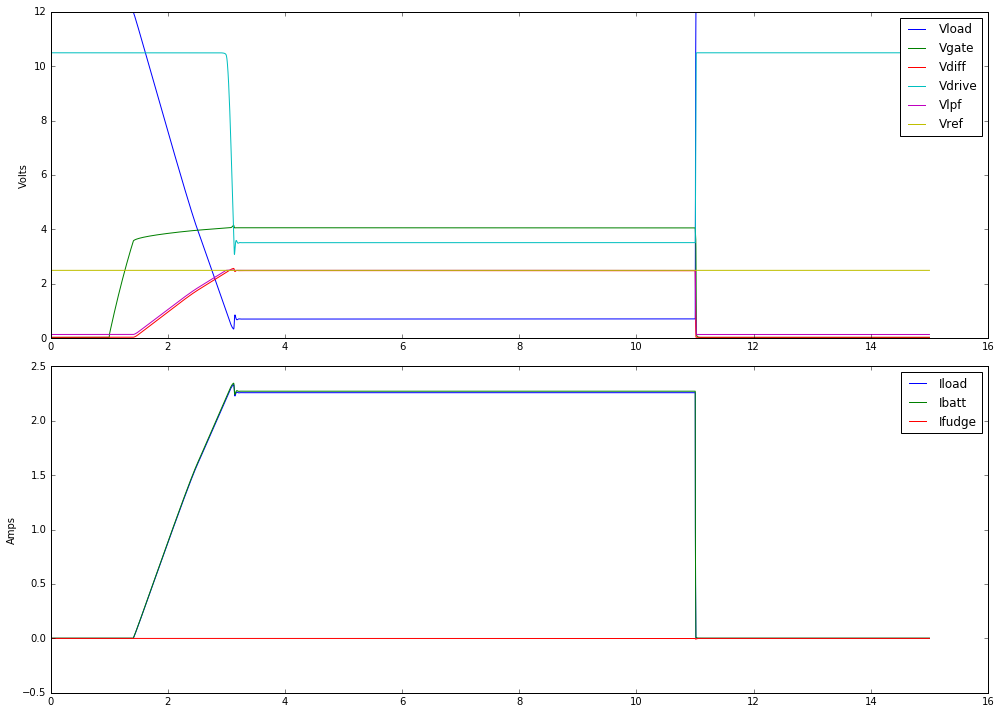

In [200]:
try:
    os.remove('out3.data')
except:
    pass

node_str = "gate diff load ref drive lpf i(vbatt) i(vload) i(vfudge)"

ksf.set_lines('extern', [
    'Vbatt VCC GND 12V',
    'Vdis disable GND 0V PULSE(5V 0V 1ms 1us 1us 10ms)',
    'Rload VCC l1 5R',
    'Lload l1 l2 1nH',
    'Vload l2 LOAD 0V',
    'Cload VCC l2, 100nF',
    'Cfudge gate fudge1 10n',
    'Vfudge fudge1 fudge2 0V',
    'Rfudge fudge2 load 1000',
    ])

ksf.set_lines('control', [
    '.control',
    #'alter c2 10pF',    
    #'alter r6 1kR',    
    'tran 10us 15ms',
    'wrdata out3 ' + node_str,
    '.endc'])

        
ksf.write_and_run('t3.cir')

t, V, I = fix.read_wrdata_file('out3.data', node_str)

t = t * 1000

I['batt'] = -I["batt"]

fix.plot_all(t, V, I) 
plt.tight_layout()

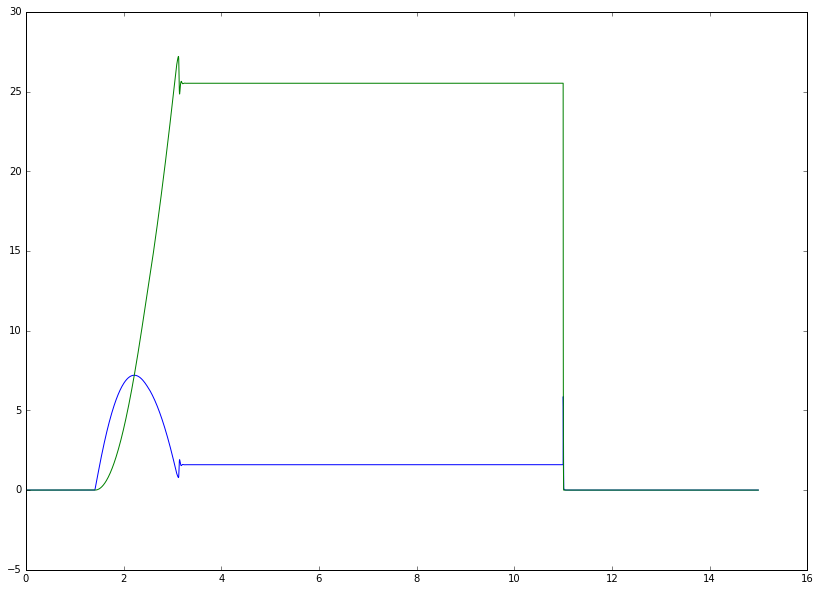

In [201]:
plt.plot(t,I["load"] * V["load"])
plt.plot(t,I["load"] * (12 - V["load"]))


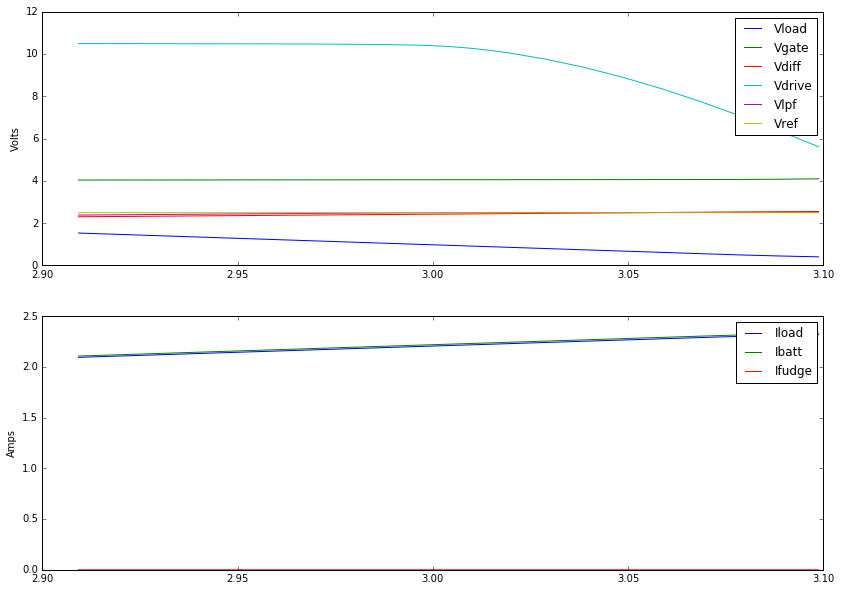

In [202]:
fix.plot_all(t, V, I, from_to=(2.9,3.1)) 

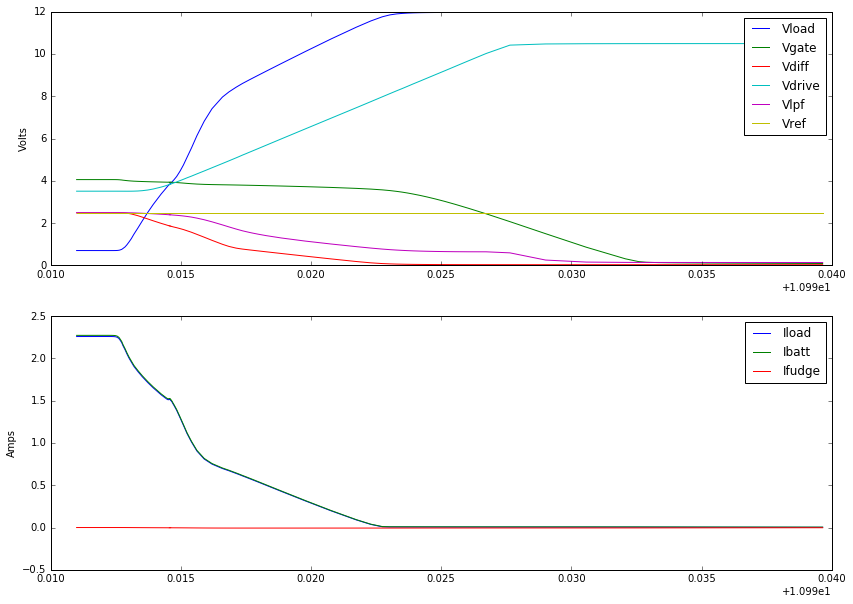

In [203]:
fix.plot_all(t, V, I, from_to=(11,11.03)) 

##########STDERR##########

Note: No ".plot", ".print", or ".fourier" lines; no simulations run



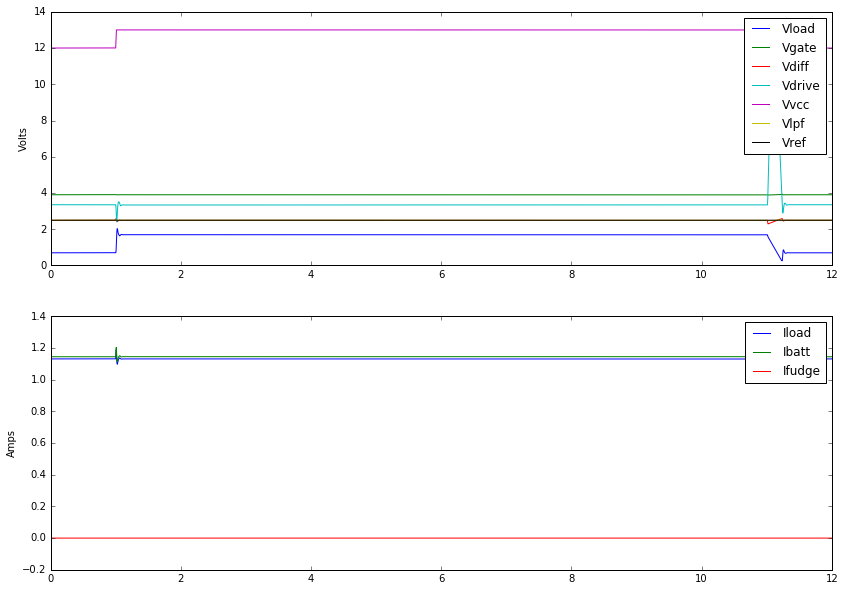

In [212]:
try:
    os.remove('out4.data')
except:
    pass

node_str = "vcc gate diff load ref drive lpf i(vbatt) i(vload) i(vfudge)"

ksf.set_lines('extern', [
    'Vbatt VCC GND 12V PULSE(12V 13V 1ms 10us 10us 10ms)',
    'Vdis disable GND 0V ',
    'Rload VCC l1 10R',
    'Vload l1 LOAD 0V',
    'Cfudge gate fudge1 10n',
    'Vfudge fudge1 fudge2 0V',
    'Rfudge fudge2 load 1000',
    ])

ksf.set_lines('control', [
    '.control',
    #'alter c2 10nF',    
    #'alter r6 1kR',    
    'tran 10us 12ms',
    'wrdata out4 ' + node_str,
    '.endc'])

        
ksf.write_and_run('t4.cir')

t, V, I = fix.read_wrdata_file('out4.data', node_str)

t = t * 1000

I['batt'] = -I["batt"]

fix.plot_all(t, V, I)    

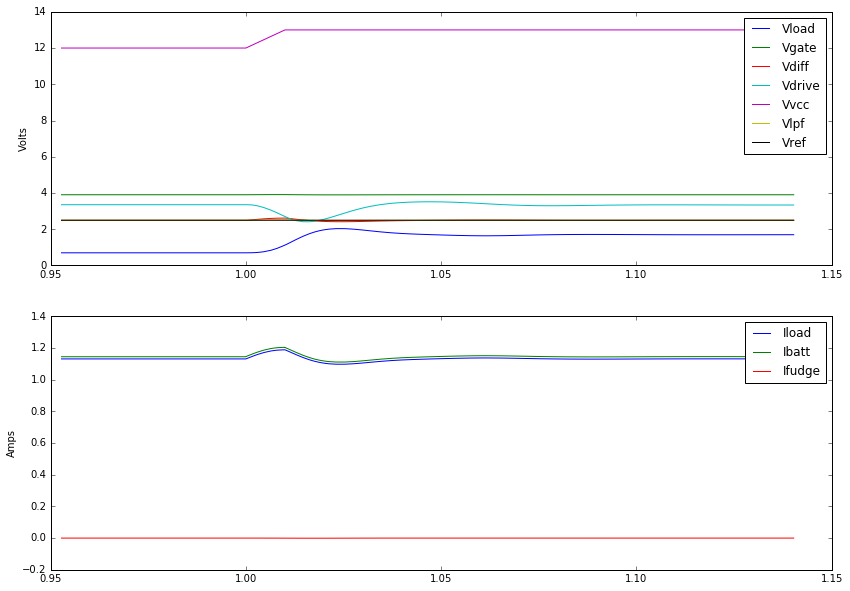

In [214]:
fix.plot_all(t, V, I, from_to=(0.95,1.15)) 

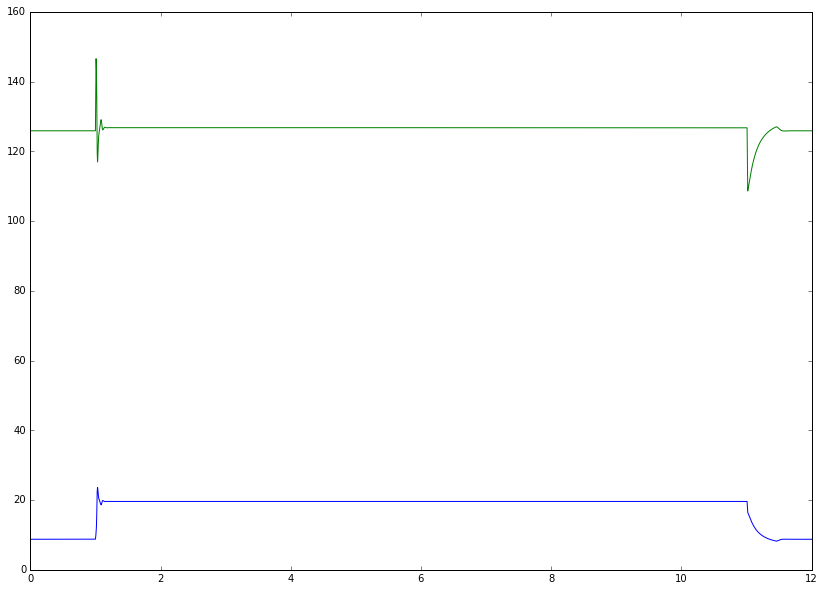

In [211]:
plt.plot(t,I["load"] * V["load"])
plt.plot(t,I["load"] * (V["vcc"] - V["load"]))
